In [1]:
import pandas as pd  # Importing pandas for data manipulation and analysis
import networkx as nx  # Importing NetworkX for creating and manipulating complex networks
import matplotlib.pyplot as plt  # Importing Matplotlib for plotting graphs
import requests  # Importing requests for making HTTP requests to APIs
from matplotlib.lines import Line2D  # Importing Line2D for custom legend creation in Matplotlib
import numpy as np  # Importing NumPy for numerical operations

# Function to get distance between two locations using GraphHopper API
def get_distance(from_place, to_place, api_key):
    # Constructing the URL for the API request
    url = f"https://graphhopper.com/api/1/route?point={from_place}&point={to_place}&vehicle=foot&locale=en&key={api_key}"
    try:
        # Making the GET request to the API
        response = requests.get(url)
        # Raise an exception if the request was unsuccessful
        response.raise_for_status()
        # Parsing the JSON response
        data = response.json()
        # Check if 'paths' key exists and has at least one path
        if 'paths' in data and len(data['paths']) > 0:
            # Extracting the distance and converting from meters to kilometers
            distance = data['paths'][0]['distance'] / 1000
            # Returning the distance rounded to two decimal places
            return round(distance, 2)
    except requests.exceptions.RequestException as e:
        # Print the error if the request fails
        print(f"Request error: {e}")
    except KeyError:
        # Print an error if the response format is unexpected
        print(f"Unexpected API response format: {response.json()}")
    return None

# Define stations and their positions (latitude, longitude)
stations = {
    'St Paul\'s': (51.5143, -0.0978),
    'Chancery Lane': (51.5186, -0.1114),
    'Holborn': (51.5171, -0.1195),
    'Oxford Circus': (51.5154, -0.1419),
    'Marble Arch': (51.5144, -0.1589),
    'Notting Hill Gate': (51.5099, -0.1966),
    'South Kensington': (51.4943, -0.1748),
    'Sloane Square': (51.4926, -0.1569),
    'St James\'s Park': (51.4994, -0.1337),
    'Embankment': (51.5074, -0.1223),
    'Temple': (51.5112, -0.1140),
    'Warren Street': (51.5247, -0.1384),
    'Green Park': (51.5067, -0.1428),
    'Victoria': (51.4966, -0.1443),
    'Pimlico': (51.4892, -0.1334),
    'Vauxhall': (51.4856, -0.1231),
    'Hyde Park Corner': (51.5025, -0.1527),
    'Piccadilly Circus': (51.5101, -0.1337),
    'Leicester Square': (51.5115, -0.1280),
    'Covent Garden': (51.5133, -0.1240),
    'Swiss Cottage': (51.5431, -0.1746),
    'Bond Street': (51.5142, -0.1440),
    'Westminster': (51.5010, -0.1246),
    'Southwark': (51.5055, -0.1044),
    'London Bridge': (51.5055, -0.0865),
}

# Define connections (edges) for different lines
# Each connection is a tuple of two station names
# The connections are defined for the red, yellow, light blue, dark blue, and grey lines

# "Central" line 
connections_red = [
    ('St Paul\'s', 'Chancery Lane'),
    ('Chancery Lane', 'Holborn'),
    ('Holborn', 'Oxford Circus'),
    ('Oxford Circus', 'Marble Arch'),
    ('Marble Arch', 'Notting Hill Gate'),
]

# "Circle" line
connections_yellow = [
    ('South Kensington', 'Sloane Square'),
    ('Sloane Square', 'St James\'s Park'),
    ('St James\'s Park', 'Embankment'),
    ('Embankment', 'Temple')
]

# "Victoria" line
connections_light_blue = [
    ('Warren Street', 'Oxford Circus'),
    ('Oxford Circus', 'Green Park'),
    ('Green Park', 'Victoria'),
    ('Victoria', 'Pimlico'),
    ('Pimlico', 'Vauxhall')
]

# "Piccadilly" line
connections_dark_blue = [
    ('Hyde Park Corner', 'Green Park'),
    ('Green Park', 'Piccadilly Circus'),
    ('Piccadilly Circus', 'Leicester Square'),
    ('Leicester Square', 'Covent Garden'),
    ('Covent Garden', 'Holborn')
]

# "Jubilee" line
connections_grey = [
    ('Swiss Cottage', 'Bond Street'),
    ('Bond Street', 'Green Park'),
    ('Green Park', 'Westminster'),
    ('Westminster', 'Southwark'),
    ('Southwark', 'London Bridge'),
]

# API key for GraphHopper
api_key = '65a48be8-40f0-4be5-9f20-7b6ba32991ca'

# Calculate distances and store them in a dictionary
distances = {}
for u, v in connections_red + connections_yellow + connections_light_blue + connections_dark_blue + connections_grey:
    # Get the distance between two stations
    distance = get_distance(f"{stations[u][0]},{stations[u][1]}", f"{stations[v][0]},{stations[v][1]}", api_key)
    if distance is not None:
        # Store the distance in the dictionary
        distances[(u, v)] = distance
    else:
        # Print a message if the distance could not be fetched
        print(f"Failed to fetch distance for: {u} -> {v}")

In [2]:
def calculate_network_statistics(G):
    # Extract distances from the graph
    # This list comprehension iterates over all edges in the graph G,
    # extracting the 'weight' attribute (which represents distance) for each edge,
    # and includes it in the distances list only if the weight is not "N/A".
    distances = [d['weight'] for u, v, d in G.edges(data=True) if d['weight'] != "N/A"]

    # Calculate total length of the transport network
    # The total length is calculated by summing up all the distances in the distances list.
    total_length = sum(distances)

    # Calculate the average distance between the stations
    # The average distance is calculated using NumPy's mean function on the distances list.
    average_distance = np.mean(distances)

    # Calculate the standard deviation of the distances between the stations
    # The standard deviation is calculated using NumPy's std function on the distances list.
    std_deviation = np.std(distances)

    # Return the calculated statistics as a tuple
    return total_length, average_distance, std_deviation

In [3]:
# Create the network graph
def create_combined_segment():
    G = nx.Graph()  # Initialize an empty graph using NetworkX

    # Define line colors
    line_colors = {
        'Piccadilly': '#29338D',  # Dark Blue
        'Jubilee': '#7B848A',    # Grey
        'Victoria': '#039DDC',     # Light Blue
        'Circle': '#FDCE04',      # Yellow
        'Central': '#E02425',      # Red
    }

    # Add nodes (stations) with their geographical coordinates
    # Iterate over each station and its coordinates (latitude, longitude) in the stations dictionary
    for station, pos in stations.items():
        # Add each station as a node to the graph G
        # The node is labeled with the station name and its position is set to the coordinates (latitude, longitude)
        # The add_node method is a function provided by the NetworkX library to add nodes to a graph
        G.add_node(station, pos=pos)

    # Define connections with distances from the API or hardcoded values
    # Create a dictionary connections_with_distances to store connections for each line
    connections_with_distances = {
        # For the 'Central' line, create a list of tuples (u, v, distance)
        # Iterate over each connection (u, v) in connections_red
        # Use the distances dictionary to get the distance for each connection (u, v)
        # If the distance is not found, use "N/A" as the default value
        'Central': [(u, v, distances.get((u, v), "N/A")) for u, v in connections_red],
        'Circle': [(u, v, distances.get((u, v), "N/A")) for u, v in connections_yellow],
        'Victoria': [(u, v, distances.get((u, v), "N/A")) for u, v in connections_light_blue],
        'Piccadilly': [(u, v, distances.get((u, v), "N/A")) for u, v in connections_dark_blue],
        'Jubilee': [(u, v, distances.get((u, v), "N/A")) for u, v in connections_grey],
    }

    # Add edges (connections)
    # Iterate over each line and its connections in the connections_with_distances dictionary
    for line, connections in connections_with_distances.items():
        # Get the color for the current line from the line_colors dictionary
        color = line_colors[line]
        # Iterate over each connection (u, v) and its distance in the current line's connections
        for u, v, distance in connections:
            if distance != "N/A":
                # Add an edge to the graph G with the specified distance as the weight and the line color
                G.add_edge(u, v, weight=distance, color=color)
            else:
                # Print a message if the distance is missing
                print(f"Skipping edge: {u} -> {v} due to missing data")

    # Use the geographical coordinates for node positions
    # Create a dictionary pos that maps each station to its coordinates (longitude, latitude)
    # Iterate over each station and its coordinates (latitude, longitude) in the stations dictionary
    # For each station, create a key-value pair in the pos dictionary
    # The key is the station name, and the value is a tuple of its coordinates in the format (longitude, latitude)
    # This format is used because plotting libraries often expect coordinates in (longitude, latitude) order
    pos = {station: (lon, lat) for station, (lat, lon) in stations.items()}

    # Create the plot
    # Create a new figure for the plot with a specified size of 14x8 inches
    plt.figure(figsize=(14, 8))

    # Draw edges with different colors
    # Iterate over each line and its corresponding color in the line_colors dictionary
    for line, color in line_colors.items():
        # Get edges for the current line
        # This list comprehension iterates over all edges in the graph G,
        # and selects the edges that have the same color as the current line.
        edges = [(u, v) for u, v, d in G.edges(data=True) if d['color'] == color]

        # Draw edges
        # Use NetworkX's draw_networkx_edges function to draw the selected edges on the plot.
        # The edges are drawn with the specified color and a width of 2.
        nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color=color, width=2)

    # Draw nodes with different colors
    for line, color in line_colors.items():
        nodes = {station for station, pos in stations.items() if any(
            # Get nodes for the current line
            station in edge for edge in connections_with_distances[line])}
        nx.draw_networkx_nodes(G, pos, nodelist=nodes, node_color=color, node_size=150)  # Draw nodes

    # Add station names near each node
    # Iterate over each node and its coordinates (x, y) in the pos dictionary
    for node, (x, y) in pos.items():
        # Add text labels for each node
        # Use Matplotlib's plt.text function to place text on the plot
        # x, y - 0.001: Position the text slightly below the node's coordinates
        # node: The text to be displayed, which is the station name
        # ha='center': Horizontally align the text to the center
        # va='center': Vertically align the text to the center
        # Create a bounding box around the text with no face color and no edge color,
        # and a rounded box style with a padding of 0.1
        plt.text(
            x, y - 0.001, node, ha='center', va='center', fontsize=8,
            color="black", bbox=dict(facecolor="none", edgecolor="none", boxstyle="round,pad=0.1")
        )  # Add text labels for each node

    # Add edge labels (distances)
    # Get edge attributes (distances)
    # Use NetworkX's get_edge_attributes function to retrieve the 'weight' attribute for all edges in the graph G
    # This returns a dictionary where the keys are edge tuples (u, v) and the values are the weights (distances)
    edge_labels = nx.get_edge_attributes(G, 'weight')
    
    # Format labels
    # Create a new dictionary formatted_labels to store the formatted edge labels
    # Iterate over each key-value pair (k, v) in the edge_labels dictionary
    # If the value (distance) is not "N/A", add the key-value pair to the formatted_labels dictionary
    # The value is formatted as a string using an f-string
    formatted_labels = {k: f"{v}" for k, v in edge_labels.items() if v != "N/A"}
    
    # Draw edge labels
    # Use NetworkX's draw_networkx_edge_labels function to draw the edge labels on the plot
    # pos: The positions of the nodes
    # edge_labels: The dictionary of formatted edge labels
    # Create a bounding box around the labels with a white face color, no edge color,
    # and a rounded box style with a padding of 0.1
    nx.draw_networkx_edge_labels(G, pos, edge_labels=formatted_labels, font_size=8,
                                 bbox=dict(facecolor="white", edgecolor="none", boxstyle="round,pad=0.1"))

    # Add key/legend
    # Use a list comprehension to create a list of Line2D objects for the legend
    # Iterate over each line and its corresponding color in the line_colors dictionary
    # Line2D is a class from Matplotlib used to create line objects.
    # [0], [0]: These are dummy data points for the line (not used in the legend).
    # color=color: Set the color of the line to the corresponding color from the line_colors dictionary.
    # lw=2: Set the line width to 2.
    # label=line: Set the label of the line to the name of the line (used in the legend).
    legend_elements = [Line2D([0], [0], color=color, lw=2, label=line)
                       for line, color in line_colors.items()]
    
    # Add legend
    # Use Matplotlib's plt.legend function to add the legend to the plot
    # handles=legend_elements: Use the list of Line2D objects created above as the legend handles
    # loc='center left': Position the legend at the center left of the plot
    # bbox_to_anchor=(1, 0.5): Adjust the legend's position using a bounding box anchor
    # frameon=True: Draw a frame around the legend
    # framealpha=1: Set the transparency of the legend frame to fully opaque
    # facecolor='white': Set the background color of the legend frame to white
    # edgecolor='black': Set the edge color of the legend frame to black
    plt.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12,
               frameon=True, framealpha=1, facecolor='white', edgecolor='black')

    # Set plot title
    plt.title("Central, Circle, Victoria, Piccadilly and Jubilee Lines with Actual Distances in Km")
    plt.axis("off")  # Hide axes

    return G, plt  # Return the graph and plot

In [7]:
print("Distances:" , distances)

Distances: {("St Paul's", 'Chancery Lane'): 1.19, ('Chancery Lane', 'Holborn'): 0.67, ('Holborn', 'Oxford Circus'): 1.86, ('Oxford Circus', 'Marble Arch'): 1.27, ('Marble Arch', 'Notting Hill Gate'): 2.88, ('South Kensington', 'Sloane Square'): 1.46, ('Sloane Square', "St James's Park"): 2.25, ("St James's Park", 'Embankment'): 1.4, ('Embankment', 'Temple'): 0.77, ('Warren Street', 'Oxford Circus'): 1.47, ('Oxford Circus', 'Green Park'): 1.24, ('Green Park', 'Victoria'): 1.42, ('Victoria', 'Pimlico'): 1.28, ('Pimlico', 'Vauxhall'): 0.95, ('Hyde Park Corner', 'Green Park'): 0.88, ('Green Park', 'Piccadilly Circus'): 0.79, ('Piccadilly Circus', 'Leicester Square'): 0.43, ('Leicester Square', 'Covent Garden'): 0.43, ('Covent Garden', 'Holborn'): 0.62, ('Swiss Cottage', 'Bond Street'): 4.52, ('Bond Street', 'Green Park'): 1.1, ('Green Park', 'Westminster'): 1.77, ('Westminster', 'Southwark'): 1.84, ('Southwark', 'London Bridge'): 1.55}


Total length of the transport network: 34.04 km
Average distance between the stations: 1.42 km
Standard deviation of the distances between the stations: 0.86 km


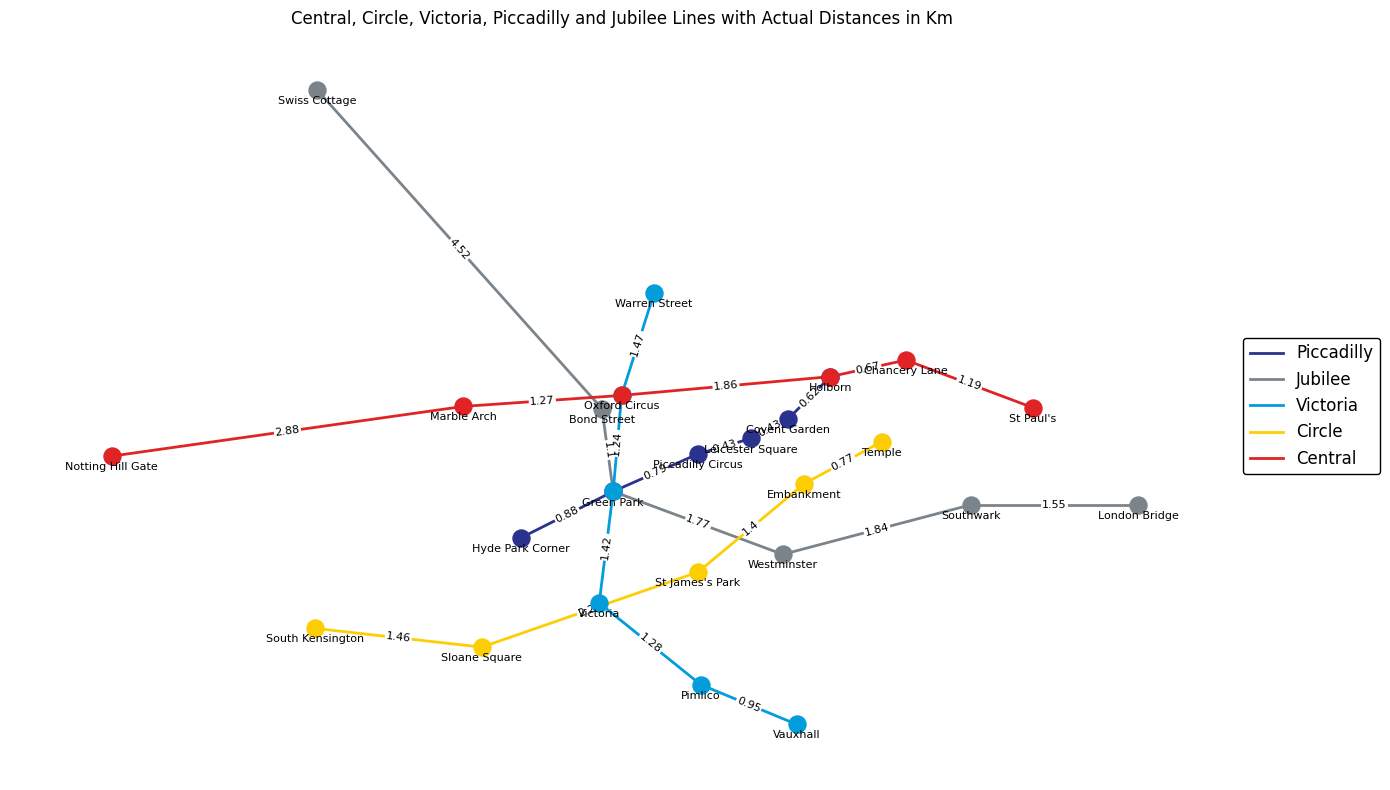

In [5]:
# Create the graph and plot
G, plt = create_combined_segment()  # Call the function to create the graph and plot

# Calculate and print the network statistics
total_length, average_distance, std_deviation = calculate_network_statistics(G)  # Calculate statistics
print(f"Total length of the transport network: {total_length:.2f} km")  # Print total length
print(f"Average distance between the stations: {average_distance:.2f} km")  # Print average distance
print(f"Standard deviation of the distances between the stations: {std_deviation:.2f} km")  # Print standard deviation

# Adjust the margins and show the plot
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)  # Adjust plot margins
plt.tight_layout()  # Automatically adjust subplot parameters to give specified padding
plt.show()  # Display the plot